In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install folium==0.2.1
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 7.7 MB/s 
  Created wheel for folium: filename=folium-0.2.1-py3-none-any.whl size=79808 sha256=77216de9e779f2eab86398fdec6d7357f0e628d80e623f8eeb4e83a9b603422e
  Stored in directory: /root/.cache/pip/wheels/9a/f0/3a/3f79a6914ff5affaf50cabad60c9f4d565283283c97f0bdccf
Successfully built folium
  Attempting uninstall: folium
    Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 35.0 MB/s 


In [ ]:
!pip install -q transformers
!pip install -q datasets

     |████████████████████████████████| 4.4 MB 28.5 MB/s 
     |████████████████████████████████| 101 kB 13.8 MB/s 
     |████████████████████████████████| 596 kB 16.2 MB/s 
     |████████████████████████████████| 6.6 MB 14.2 MB/s 
     |████████████████████████████████| 362 kB 28.4 MB/s 
     |████████████████████████████████| 1.1 MB 61.2 MB/s 
     |████████████████████████████████| 140 kB 73.2 MB/s 
     |████████████████████████████████| 212 kB 76.5 MB/s 
     |████████████████████████████████| 127 kB 76.1 MB/s 
     |████████████████████████████████| 94 kB 3.9 MB/s 
     |████████████████████████████████| 144 kB 76.7 MB/s 
     |████████████████████████████████| 271 kB 75.2 MB/s 


In [ ]:
import torch
from datasets import load_dataset
import pandas as pd
import collections
from datasets import load_dataset , load_metric
import datasets
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from transformers import TrainingArguments, Trainer
from transformers import default_data_collator

In [ ]:
dataset_persian_qa = load_dataset("SajjadAyoubi/persian_qa")
dataset_pquad = load_dataset("Shayanvsf/pquad_public")


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/root/.cache/huggingface/datasets/downloads/6bed7cf0f82631fb5231ba39906ba835ef73fb005b6e7371869afd01e5f98ddc


Generating validation split: 0 examples [00:00, ? examples/s]

/root/.cache/huggingface/datasets/downloads/3b640ed1f99bd004e2d515cf66938e75cd85d8f359739d9ba644ed3dc533b849
Dataset persian_qa downloaded and prepared to /root/.cache/huggingface/datasets/SajjadAyoubi___persian_qa/persian_qa/1.0.0/adcc9e82d1a679ba85f7958663d8e771894c35e2fbc6a92d9ea2b6a8a72f9225. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/root/.cache/huggingface/datasets/downloads/c398ba29001242851de4d8dc468625e7eeccc2041e8168871e972293b3745bde


Generating validation split: 0 examples [00:00, ? examples/s]

/root/.cache/huggingface/datasets/downloads/d87772b342fcc0d549d5a7a63e6b8873e2ae95e5c07919932e587397f545910d


Generating test split: 0 examples [00:00, ? examples/s]

/root/.cache/huggingface/datasets/downloads/e6f3da0212a37e85850d4f58a11a3e7bff446fcd83b57e8aeb54bbafa8ed95c8
Dataset pquad_public downloaded and prepared to /root/.cache/huggingface/datasets/Shayanvsf___pquad_public/pquad_public/1.0.0/20f4f02802eb56c6b1f41e0fd9e4b3452884817ce8592df8fe863576c1569264. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

#Loading datasets

In [ ]:
dataset_persian_qa 

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 9008
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 930
    })
})

In [ ]:
dataset_pquad

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 7878
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1157
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 964
    })
})

In [ ]:
train_dataset = Dataset.from_dict(pd.concat([pd.DataFrame(dataset_persian_qa['train']),pd.DataFrame(dataset_pquad['train'])]))
test_dataset = Dataset.from_dict(pd.DataFrame(dataset_pquad['test']))
validation_dataset = Dataset.from_dict(pd.concat([pd.DataFrame(dataset_persian_qa['validation']),pd.DataFrame(dataset_pquad['validation'])]))
dataset = datasets.DatasetDict({"train":train_dataset, "validation":validation_dataset, "test":test_dataset})

## Train Data

In [ ]:
pd.DataFrame(data = dataset['train']).head()

,title,context,question,answers
0,شرکت فولاد مبارکه اصفهان,شرکت فولاد مبارکۀ اصفهان، بزرگ‌ترین واحد صنعتی...,شرکت فولاد مبارکه در کجا واقع شده است,"{'answer_start': [114], 'text': ['در شرق شهر م..."
1,شرکت فولاد مبارکه اصفهان,شرکت فولاد مبارکۀ اصفهان، بزرگ‌ترین واحد صنعتی...,فولاد مبارکه چند بار برنده جایزه شرکت دانشی را...,"{'answer_start': [263], 'text': ['۶']}"
2,شرکت فولاد مبارکه اصفهان,شرکت فولاد مبارکۀ اصفهان، بزرگ‌ترین واحد صنعتی...,شرکت فولاد مبارکه در سال ۱۳۹۱ چه جایزه ای برد؟,"{'answer_start': [413], 'text': ['تندیس زرین ج..."
3,شرکت فولاد مبارکه اصفهان,شرکت فولاد مبارکۀ اصفهان، بزرگ‌ترین واحد صنعتی...,بزرگ ترین مجموعه تولید فولاد ایران چیست؟,"{'answer_start': [0], 'text': ['شرکت فولاد مبا..."
4,شرکت فولاد مبارکه اصفهان,شرکت فولاد مبارکۀ اصفهان، بزرگ‌ترین واحد صنعتی...,فولاد مبارکه در چه سالی احداث شد؟,"{'answer_start': [504], 'text': ['۱۳۷۱']}"


## Validation Data

In [ ]:
pd.DataFrame(data = dataset['validation']).head()

,title,context,question,answers
0,باشگاه فوتبال رئال مادرید,باشگاه فوتبال رئال مادرید یک باشگاه حرفه‌ای فو...,پایتخت اسپانیا کجاست؟,"{'answer_start': [19, 19], 'text': ['مادرید', ..."
1,باشگاه فوتبال رئال مادرید,باشگاه فوتبال رئال مادرید یک باشگاه حرفه‌ای فو...,بر چه اساسی رئال موفق ترین تیم در تاریخ فوتبال...,"{'answer_start': [218, 208], 'text': ['فیفا', ..."
2,باشگاه فوتبال رئال مادرید,باشگاه فوتبال رئال مادرید یک باشگاه حرفه‌ای فو...,رئال مادرید چند بار در لیگ قهرمانان اروپا به ع...,"{'answer_start': [329, 329], 'text': ['۱۳', '۱..."
3,باشگاه فوتبال رئال مادرید,باشگاه فوتبال رئال مادرید یک باشگاه حرفه‌ای فو...,معنی واژه رئال به اسپانیایی چیست؟,"{'answer_start': [648, 648], 'text': ['سلطنتی'..."
4,باشگاه فوتبال رئال مادرید,باشگاه فوتبال رئال مادرید یک باشگاه حرفه‌ای فو...,تیم رئال مادرید برای کجاست؟,"{'answer_start': [61, 76], 'text': ['مادرید، پ..."


## Model Init

In [ ]:
model_checkpoint = "m3hrdadfi/albert-fa-base-v2"
max_length = 256 #512 # The maximum length of a feature (question and context)
doc_stride = 128 # 256 # The authorized overlap between two part of the context when splitting it is needed.
batch_size = 8
lr = 3e-5
epoch = 3

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/434 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

In [ ]:
tokenizer(".اسمتون چی بود ؟", "اسم من شایان است")

{'input_ids': [2, 15, 58854, 2061, 3069, 2083, 303, 4, 4856, 2078, 9920, 2045, 4], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

## Create several input features from long contex

In [ ]:
for i, example in enumerate(dataset["train"]):
    if len(tokenizer(example["question"], example["context"])["input_ids"]) > max_length:
        print('Find one')
        break
        
example = dataset["train"][i]

Find one


In [ ]:
example

{'answers': {'answer_start': [79], 'text': ['آدولف هیتلر']},
 'context': 'دروغ بزرگ  یا دروغ گوبلزی اصطلاح و تکنیکی است در پروپاگاندا، که اولین بار توسط آدولف هیتلر از آن استفاده کرد و نمایندهٔ تکنیکی تبلیغاتی در دنیای سیاست است. آدولف هیتلر در کتاب نبرد من، می\u200cگوید مردم شکست آلمان در جنگ جهانی اول را به این دلیل پذیرفتند که یهودی\u200cهای دارای نفوذ در مطبوعات از این تکنیک استفاده کردند. از نظر او این روش مستلزم آن است که دروغ چنان عظیم باشد که هیچ\u200cکس باور نکند که «کسی آنقدر گستاخ باشد که چنین بی\u200cشرمانه حقیقت را تحریف کند». اولین مورد استفادهٔ دروغ بزرگ در این جملهٔ معروف او مستند شده\u200cاست: «در دروغ بزرگ همواره نیروی قابل باور بودن موجود است.» بعدها یوزف گوبلز که وزیر تبلیغات هیتلر بود این تئوری را با کمی تغییر بدین گونه بیان کرد که دروغ بزرگ یکی از روش\u200cهای تبلیغاتی مورد استفادهٔ انگلستان است که دروغ بزرگی می\u200cگویند و در ضمن تحت هر شرایطی بر صحت آن پافشاری می\u200cکنند.شایع است که گوبلز روایت خود از روش دروغ بزرگ را بدون نسبت دادن آن به یهودی\u200cها یا متف

In [ ]:
len(tokenizer(example["question"], example["context"])["input_ids"])

291

In [ ]:
len(tokenizer(example["question"], example["context"], max_length = max_length, truncation="only_second")["input_ids"])

256

## return_overflowing_tokens

In [ ]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length = max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    stride=doc_stride
)

In [ ]:
[len(x) for x in tokenized_example["input_ids"]] 

[256, 171]

In [ ]:
len(tokenized_example["input_ids"])

2

In [ ]:
for x in tokenized_example["input_ids"][:2]:
    print(tokenizer.decode(x))

[CLS] مخترع دروغ بزرگ کیه ؟ [SEP] دروغ بزرگ یا دروغ گوبلزی اصطلاح و تکنیکی است در پروپاگاندا ، که اولین بار توسط ادولف هیتلر از ان استفاده کرد و نماینده تکنیکی تبلیغاتی در دنیای سیاست است. ادولف هیتلر در کتاب نبرد من ، میگوید مردم شکست المان در جنگ جهانی اول را به این دلیل پذیرفتند که یهودیهای دارای نفوذ در مطبوعات از این تکنیک استفاده کردند. از نظر او این روش مستلزم ان است که دروغ چنان عظیم باشد که هیچکس باور نکند که [UNK] کسی انقدر گستاخ باشد که چنین بیشرمانه حقیقت را تحریف کند [UNK]. اولین مورد استفاده دروغ بزرگ در این جمله معروف او مستند شدهاست : [UNK] در دروغ بزرگ همواره نیروی قابل باور بودن موجود است. [UNK] بعدها یوزف گوبلز که وزیر تبلیغات هیتلر بود این تيوری را با کمی تغییر بدین گونه بیان کرد که دروغ بزرگ یکی از روشهای تبلیغاتی مورد استفاده انگلستان است که دروغ بزرگی میگویند و در ضمن تحت هر شرایطی بر صحت ان پافشاری میکنند. شایع است که گوبلز روایت خود از روش دروغ بزرگ را بدون نسبت دادن ان به یهودیها یا متفقین مورد استفاده قرار میداد. این روایت بدون منبع شایعترین نمونه استفاده از 

## offset_mapping

In [ ]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride
)
print(tokenized_example["offset_mapping"][0][:100])

[(0, 0), (0, 5), (6, 10), (11, 15), (16, 19), (19, 20), (0, 0), (0, 4), (5, 9), (11, 13), (14, 18), (19, 24), (24, 25), (26, 32), (33, 34), (35, 41), (42, 45), (46, 48), (49, 59), (59, 60), (61, 63), (64, 69), (70, 73), (74, 78), (79, 84), (85, 90), (91, 93), (94, 96), (97, 104), (105, 108), (109, 110), (111, 118), (120, 126), (127, 135), (136, 138), (139, 144), (145, 150), (151, 154), (154, 155), (156, 161), (162, 167), (168, 170), (171, 175), (176, 180), (181, 183), (183, 184), (185, 192), (193, 197), (198, 202), (203, 208), (209, 211), (212, 215), (216, 221), (222, 225), (226, 228), (229, 231), (232, 235), (236, 240), (241, 249), (250, 252), (253, 262), (263, 268), (269, 273), (274, 276), (277, 284), (285, 287), (288, 291), (292, 297), (298, 305), (306, 311), (311, 312), (313, 315), (316, 319), (320, 322), (323, 326), (327, 330), (331, 337), (338, 340), (341, 344), (345, 347), (348, 352), (353, 357), (358, 362), (363, 367), (368, 370), (371, 377), (378, 382), (383, 387), (388, 390),

In [ ]:
len(tokenized_example["offset_mapping"])

2

In [ ]:
first_token_id = tokenized_example["input_ids"][0][1]
offsets = tokenized_example["offset_mapping"][0][1]
print(tokenizer.convert_ids_to_tokens([first_token_id])[0], example["question"][offsets[0]:offsets[1]])

مخترع مخترع


## return 0 if a token is in the question, else return 1.

In [ ]:
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

[None, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, None]


## Detecting start and end character of a anwser

In [ ]:
answers = example["answers"]
start_char = answers["answer_start"][0]
end_char = start_char + len(answers["text"][0])

# Start token index of the current span in the text.
token_start_index = 0
while sequence_ids[token_start_index] != 1:
    token_start_index += 1

# End token index of the current span in the text.
token_end_index = len(tokenized_example["input_ids"][0]) - 1
while sequence_ids[token_end_index] != 1:
    token_end_index -= 1

# Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
offsets = tokenized_example["offset_mapping"][0]
if (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char): # searching in the context
    # Move the token_start_index and token_end_index to the two ends of the answer.
    # Note: we could go after the last offset if the answer is the last word (edge case).
    while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
        token_start_index += 1
    start_position = token_start_index - 1
    while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1
    end_position = token_end_index + 1
    print(start_position, end_position)
else:
    print("The answer is not in this feature.")

24 25


In [ ]:
print(tokenizer.decode(tokenized_example["input_ids"][0][start_position: end_position+1]))
print(answers["text"][0])

ادولف هیتلر
آدولف هیتلر


## Putting it all together

In [ ]:
def prepare_train_features(examples):
    examples["question"] = [q.lstrip() for q in examples["question"]]
    #Assume padding on the right.
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,)
    
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping") #extract overflow_to_sample_mapping
    offset_mapping = tokenized_examples.pop("offset_mapping") #extract offset_mapping
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []
    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])
            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1
            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1
            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [ ]:
# the datasets library does cashing itself, batched is multitreading for fast-tokenizer
tokenized_ds = dataset.map(prepare_train_features, batched=True, remove_columns=dataset["train"].column_names)

Parameter 'function'=<function prepare_train_features at 0x7efe34b9f4d0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/624M [00:00<?, ?B/s]

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initia

In [ ]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    output_dir = f"/content/drive/MyDrive/CA6/checkpoints/{model_name}-finetuned-ParSQuAD",
    overwrite_output_dir = True,
    save_strategy = "steps",
    save_steps = 12000,
    evaluation_strategy = "epoch",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epoch,
    weight_decay=0.0001)

In [ ]:
data_collator = default_data_collator
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds['train'],
    eval_dataset=tokenized_ds['validation'],
    tokenizer=tokenizer)

In [ ]:
# start training
trainer.train()
#trainer.save_model(trainer.save_model("PersianQA(ParsBERT)-trained"))

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 18321
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6873


Epoch,Training Loss,Validation Loss
1,1.527100,1.318570
2,0.835100,1.353809
3,0.401400,1.746275


***** Running Evaluation *****
  Num examples = 2167
  Batch size = 8
***** Running Evaluation *****
  Num examples = 2167
  Batch size = 8
***** Running Evaluation *****
  Num examples = 2167
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=6873, training_loss=1.0364199898812894, metrics={'train_runtime': 2879.0426, 'train_samples_per_second': 19.091, 'train_steps_per_second': 2.387, 'total_flos': 6909992221538292.0, 'train_loss': 1.0364199898812894, 'epoch': 3.0})

# Evaluation

## Trainer output type

In [ ]:
for batch in trainer.get_eval_dataloader():
    break
batch = {k: v.to(trainer.args.device) for k, v in batch.items()}
with torch.no_grad():
    output = trainer.model(**batch)
output.keys()

odict_keys(['loss', 'start_logits', 'end_logits'])

In [ ]:
output.start_logits.shape, output.end_logits.shape

(torch.Size([8, 229]), torch.Size([8, 229]))

In [ ]:
output.start_logits.argmax(dim=-1), output.end_logits.argmax(dim=-1)

(tensor([ 17,   0,  81, 141,  18, 149, 198,   0], device='cuda:0'),
 tensor([ 17,  55,  81, 141,  22, 151, 198,   0], device='cuda:0'))

## picking the n_best prediction

In [ ]:
n_best_size = 20
import numpy as np

start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": "" # We need to find a way to get back the original substring corresponding to the answer in the context
                }
            )

## create validation feature

In [ ]:
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]
    # print(examples["question"])
    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []
    
    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [ ]:
# validation_features = dataset["validation"].map(
#     prepare_validation_features,
#     batched=True,
#     remove_columns=dataset["validation"].column_names
# )

In [ ]:
test_features = dataset["test"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=dataset["test"].column_names
)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
test_features

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 995
})

In [ ]:
raw_predictions = trainer.predict(test_features)

The following columns in the test set don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id. If offset_mapping, example_id are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 995
  Batch size = 8


In [ ]:
test_features.set_format(type=test_features.format["type"], columns=list(test_features.features.keys()))

## Evaluating model for a single example

In [ ]:
max_answer_length = 30
start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
offset_mapping = test_features[0]["offset_mapping"]
# The first feature comes from the first example. For the more general case, we will need to be match the example_id to
# an example index
context = dataset["test"][1]["context"]

# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
        # to part of the input_ids that are not in the context.
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or offset_mapping[start_index] is None
            or offset_mapping[end_index] is None
        ):
            continue
        # Don't consider answers with a length that is either < 0 or > max_answer_length.
        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": context[start_char: end_char]
                }
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[:n_best_size]
valid_answers

[{'score': 16.20041, 'text': 'شد'},
 {'score': 13.972277, 'text': 'تأسیس شد'},
 {'score': 10.525411, 'text': 'شد و'},
 {'score': 8.297277, 'text': 'تأسیس شد و'},
 {'score': 7.1369925, 'text': 'شد و تا'},
 {'score': 7.1180415, 'text': 'شد و تا به'},
 {'score': 5.6815157, 'text': 'شد و تا به حال موفق'},
 {'score': 4.908859, 'text': 'تأسیس شد و تا'},
 {'score': 4.889908, 'text': 'تأسیس شد و تا به'},
 {'score': 3.7309828, 'text': 'شد و تا به حال موفق به'},
 {'score': 3.4533823, 'text': 'تأسیس شد و تا به حال موفق'},
 {'score': 2.5910842, 'text': 'تأسیس'},
 {'score': 2.02241, 'text': 'شد و تا به حال'},
 {'score': 1.5028491, 'text': 'تأسیس شد و تا به حال موفق به'},
 {'score': 0.1567049, 'text': '۱۸۹۹ تأسیس شد'},
 {'score': 0.09278488, 'text': 'این تیم در سال ۱۸۹۹ تأسیس شد'},
 {'score': -0.20572376, 'text': 'تأسیس شد و تا به حال'},
 {'score': -0.62593794, 'text': 'شد و تا به حال موفق به کسب'},
 {'score': -1.199455, 'text': 'تا'},
 {'score': -1.2184063, 'text': 'تا به'}]

In [ ]:
dataset["test"][1]["answers"]

{'answer_start': [54], 'text': ['یک']}

## feature per example 

In [ ]:
# import collections

# examples = dataset["test"]
# features = validation_features

# example_id_to_index = {int(k): i for i, k in enumerate(examples["id"])}
# features_per_example = collections.defaultdict(list)
# for i, feature in enumerate(features):
#     features_per_example[example_id_to_index[feature["example_id"]]].append(i)

## put it all together

In [ ]:
from tqdm.auto import tqdm

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = None , max_answer_length = None):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {int(k): i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []
        
        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}
        
        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        # if not squad_v2:
        #predictions[example["id"]] = best_answer["text"]
        # else:
        answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
        predictions[example["id"]] = answer

    return predictions

In [ ]:
dataset["test"]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 964
})

In [ ]:
a = [1,2,3]
a.index(1)

0

## Calculating final predictions

In [ ]:
c=0
em = np.zeros((9,2))
bs = [10,20,30]
mal = [10,15,20]
fp = []
for b in bs:
  for m in mal:
    fp.append(postprocess_qa_predictions(dataset["test"], test_features, raw_predictions.predictions , b, m))
    em[c,:]=np.array([b,m])
    c+=1

Post-processing 964 example predictions split into 995 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 995 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 995 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 995 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 995 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 995 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 995 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 995 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 995 features.


  0%|          | 0/964 [00:00<?, ?it/s]

In [ ]:
em

array([[10., 10.],
       [10., 15.],
       [10., 20.],
       [20., 10.],
       [20., 15.],
       [20., 20.],
       [30., 10.],
       [30., 15.],
       [30., 20.]])

In [ ]:
metric = load_metric("squad_v2") 

In [ ]:
EX = []
F1 = []
for i,pred in enumerate(fp):
  formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in pred.items()] #(method 1)
  # formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()] ##(method 2)
  references = [{"id": ex["id"], "answers": ex["answers"]} for ex in dataset["test"]]
  print("\n" , metric.compute(predictions=formatted_predictions, references=references))
  EX.append(metric.compute(predictions=formatted_predictions, references=references)['exact'])
  F1.append(metric.compute(predictions=formatted_predictions, references=references)['f1'])


 {'exact': 64.83402489626556, 'f1': 78.77704672991916, 'total': 964, 'HasAns_exact': 56.343792633015006, 'HasAns_f1': 74.680863639348, 'HasAns_total': 733, 'NoAns_exact': 91.77489177489177, 'NoAns_f1': 91.77489177489177, 'NoAns_total': 231, 'best_exact': 64.83402489626556, 'best_exact_thresh': 0.0, 'best_f1': 78.77704672991918, 'best_f1_thresh': 0.0}

 {'exact': 67.32365145228216, 'f1': 81.64029876131966, 'total': 964, 'HasAns_exact': 59.61800818553888, 'HasAns_f1': 78.44645021270415, 'HasAns_total': 733, 'NoAns_exact': 91.77489177489177, 'NoAns_f1': 91.77489177489177, 'NoAns_total': 231, 'best_exact': 67.32365145228216, 'best_exact_thresh': 0.0, 'best_f1': 81.64029876131966, 'best_f1_thresh': 0.0}

 {'exact': 67.73858921161826, 'f1': 82.801897503487, 'total': 964, 'HasAns_exact': 60.16371077762619, 'HasAns_f1': 79.9741189541084, 'HasAns_total': 733, 'NoAns_exact': 91.77489177489177, 'NoAns_f1': 91.77489177489177, 'NoAns_total': 231, 'best_exact': 67.73858921161826, 'best_exact_thresh

In [ ]:
np.array(EX)

array([64.8340249 , 67.32365145, 67.73858921, 64.8340249 , 67.32365145,
       67.73858921, 64.8340249 , 67.32365145, 67.73858921])

In [ ]:
df = pd.DataFrame(np.hstack([em , np.array(EX).reshape(-1,1) , np.array(F1).reshape(-1,1)]),columns = ['best_n' , 'max_length','exact','f1'])
df.head()

,best_n,max_length,exact,f1
0,10.0,10.0,64.834025,78.777047
1,10.0,15.0,67.323651,81.640299
2,10.0,20.0,67.738589,82.801898
3,20.0,10.0,64.834025,78.794464
4,20.0,15.0,67.323651,81.640299


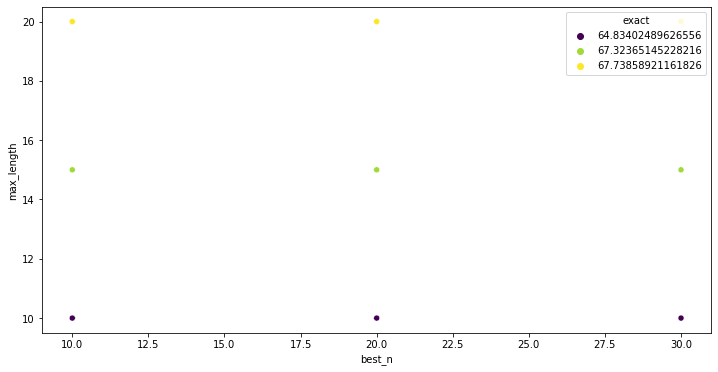

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,6))
sns.scatterplot(x = 'best_n' , y = 'max_length' , data = df , hue = 'exact' , palette = 'viridis')

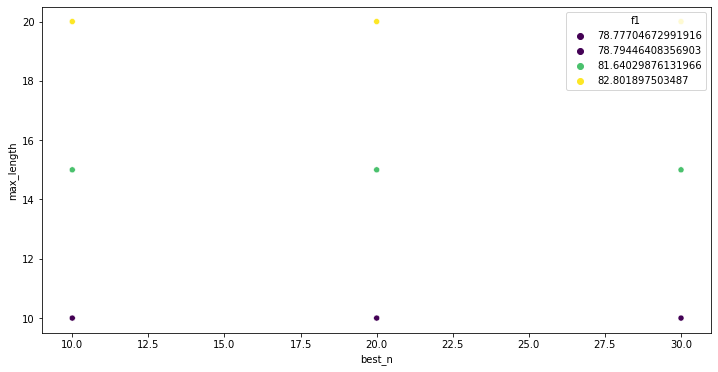

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,6))
sns.scatterplot(x = 'best_n' , y = 'max_length' , data = df , hue = 'f1' , palette = 'viridis')

In [ ]:
references[15]

{'answers': {'answer_start': [390], 'text': ['بایرن مونیخ']}, 'id': 1719487.0}

In [ ]:
formatted_predictions[15]

{'id': 1719487.0,
 'no_answer_probability': 0.0,
 'prediction_text': 'بایرن مونیخ'}